$
\newcommand{\ud}{\, \text{d}}
$

#### Frenchel Mini-Max Learning using GMM proposal

In [1]:
import os
import sys
from time import time

import numpy as np
import tensorflow as tf

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

# Allow growth to curb resource drain

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement=True

sess = tf.Session(config=config)

In [2]:
class flags:
    
    dim = 2
    
    # optimization
    learning_rate = 1e-3 # Base learning rate
    lr_decay = 0.999995 # Learning rate decay, applied every step of the optimization
    
    batch_size = 128 # Batch size during training per GPU
    
    
FLAGS = flags()
args = FLAGS

DTYPE = tf.float32

In [3]:
def int_shape(x):
    return list(map(int, x.get_shape()))

def print_shape(x,varname='variable'):
    if x is None:
        print('%s size: None' % (varname))
        return
    x_shape = x.shape.as_list()
    # print('%s size: [%d,%d,%d]' % (varname,x_shape[1],x_shape[2],x_shape[3]))
    print(varname+':')
    print(x_shape)

In [4]:
def tf_eval(tf_tensor,n_samples,feed_dict=None):
    
    MLOOP = np.int(np.ceil(np.float(n_samples)/args.batch_size))
    
    dd = tf_tensor.shape.as_list()[1:]
    dd.insert(0,n_samples)
    
    x = np.zeros(dd)
    
    for mloop in range(MLOOP):
        
        st = mloop*args.batch_size
        ed = min((mloop+1)*args.batch_size,n_samples)
        
        if feed_dict is not None:
            feed_dict_i = dict()
            for key in feed_dict.keys():
                feed_dict_i[key] = np.random.randn(*int_shape(key))
                feed_dict_i[key][:ed-st] = feed_dict[key][st:ed]
            y = sess.run(tf_tensor,feed_dict=feed_dict_i)
        else:
            y = sess.run(tf_tensor)
        
        x[st:ed] = y[:ed-st]
    
    return x

def tf_eval_list(tf_tensor_list,n_samples,feed_dict=None):
    
    if isinstance(tf_tensor_list, list)==False:
        print('Input not a list')
        return None
    
    MLOOP = np.int(np.ceil(n_samples/args.batch_size))
    
    res = dict()

    for key in tf_tensor_list:
        dd = key.shape.as_list()[1:]
        dd.insert(0,n_samples)
        res[key] = np.zeros(dd)
    
    for mloop in range(MLOOP):
        
        st = mloop*args.batch_size
        ed = min((mloop+1)*args.batch_size,n_samples)
        
        if feed_dict is not None:
            feed_dict_i = dict()
            for key in feed_dict.keys():
                feed_dict_i[key] = np.random.randn(*int_shape(key))
                feed_dict_i[key][:ed-st] = feed_dict[key][st:ed]
            # print(feed_dict_i)
            y = sess.run(tf_tensor_list,feed_dict=feed_dict_i)
        else:
            y = sess.run(tf_tensor_list)
        
        for i in range(len(tf_tensor_list)):
            res[tf_tensor_list[i]][st:ed] = y[i][:ed-st]
    
    return res

In [5]:

def tf_gauss_logpdf(x,mu=0.,sig2=1.):
    
    return -tf.square(x-mu)/(2.*sig2)-.5*tf.log(2.*np.pi*sig2)

def tf_unnorm_gauss_logpdf(x,mu=0.,sig2=1.):
    
    return -tf.square(x-mu)/(2.*sig2)


def tf_unif_sampler(n_samples,dim=1,a=0.,b=1.):
    
    return a+(b-a)*tf.random_uniform([n_samples,dim])

#### Banana distribution
* $\log p(x_1,x_2) = \displaystyle{\frac{1}{2}\left(\frac{(x_2-\mu_2)^2}{\sigma_2^2}+\frac{(x_1-\frac{x_2^2}{4})^2}{\sigma_1^2}\right)}$
* $\log p(x_1,x_2) = \displaystyle{\frac{1}{2}\left(\frac{(x_2-\mu_2)^2}{\sigma_2^2}+\frac{(x_1-\left(\frac{x_2}{\kappa}\right)^2)^2}{\sigma_1^2}\right)} + Z(\mu, \sigma_1^2, \sigma_2^2, \kappa)$
  * $(\mu_2 = 0, \sigma_2^2 = 2., \sigma_1^2 = 1, \kappa = 2)$

In [6]:
# Toy models used in our study

def banana_logpdf(x,mu_2=0.,sig2_1=1.,sig2_2=2.,kappa=2.):
    
    neg_psi_x = banana_unnorm_logpdf(x,mu_2, sig2_1, sig2_2, kappa)
    neg_logZ_psi = banana_partfunc(mu_2, sig2_1, sig2_2, kappa)
    
    return neg_psi_x+neg_logZ_psi

def banana_partfunc(mu_2=0.,sig2_1=1.,sig2_2=2.,kappa=2.):
    
    # mu_1 = np.square(x2/kappa)
    return -.5*(np.log(2.*np.pi*sig2_1)+np.log(2.*np.pi*sig2_2))

def banana_unnorm_logpdf(x,mu_2=0.,sig2_1=1.,sig2_2=2.,kappa=2.):
    
    x1 = x[:,0].reshape([-1,1])
    x2 = x[:,1].reshape([-1,1])
    
    mu_1 = np.square(x2/kappa)
    
    return -.5*(((x1-mu_1))**2/sig2_1+((x2-mu_2))**2/sig2_2)


def banana_sampler(n,mu_2=0.,sig2_1=1.,sig2_2=2.,kappa=2.):
    
    sig_1 = np.sqrt(sig2_1)
    sig_2 = np.sqrt(sig2_2)
    
    x2 = mu_2 + sig_2*np.random.randn(n,1)
    
    mu_1 = np.square(x2/kappa)
    
    x1 = mu_1 + sig_1*np.random.randn(n,1)
    
    # x = np.concatenate((x2,10.*x1),axis=1)
    x = np.concatenate((x1,x2),axis=1)
    
    return x

def tf_banana_unnorm_logpdf(x,mu_2=0.,sig2_1=1.,sig2_2=2.,kappa=2.):
    
    x1 = tf.reshape(x[:,0],[-1,1])
    x2 = tf.reshape(x[:,1],[-1,1])
    
    mu_1 = tf.square(x2/kappa)
    
    return -.5*(tf.square((x1-mu_1))/sig2_1+tf.square((x2-mu_2))/sig2_2)

def tf_banana_partfunc(mu_2=0.,sig2_1=1.,sig2_2=2.,kappa=2.):
    
    # mu_1 = np.square(x2/kappa)
    return -.5*(tf.log(2.*np.pi*sig2_1)+tf.log(2.*np.pi*sig2_2))

def tf_banana_logpdf(x,mu_2=0.,sig2_1=1.,sig2_2=2.,kappa=2.):
    
    neg_psi_x = tf_banana_unnorm_logpdf(x,mu_2, sig2_1, sig2_2, kappa)
    neg_logZ_psi = tf_banana_partfunc(mu_2, sig2_1, sig2_2, kappa)
    
    return neg_psi_x+neg_logZ_psi

In [7]:
def u1_tf_param(z, denom1=0.4, subt1=2, denom2=0.6, subt2=2):
    z_norm = tf.sqrt(tf.reduce_sum(tf.square(z),axis=1,keepdims=True))
    z1, z2 = z[:,:1], z[:,1:]
    return .5*((z_norm-subt1)/denom1)**2 - tf.log(tf.exp(-.5*((z1-subt2)/denom2)**2)+tf.exp(-.5*((z1+subt2)/denom2)**2))

def u1_np_param(z, denom1=0.4, subt1=2, denom2=0.6, subt2=2):
    z_norm = np.sqrt(np.sum(z**2,axis=1))
    z1, z2 = z[:,:1].reshape(-1,), z[:,1:].reshape(-1,)
    return .5*((z_norm-subt1)/denom1)**2 - np.log(np.exp(-.5*((z1-subt2)/denom2)**2)+np.exp(-.5*((z1+subt2)/denom2)**2))

def w1_np_param(z, denom=4):
    z1 = z[:,:1].reshape(-1,)
    z2 = z[:,1:].reshape(-1,)
    return np.sin(2*np.pi*z1/denom)

def w1_tf_param(z, denom=4):
    z1 = z[:,:1]
    z2 = z[:,1:]
    return tf.sin(2*tf.constant(np.pi,dtype=DTYPE)*z1/denom)

def u2_np_param(z, denom=0.4, denom_w1=4):
    z1, z2 = z[:,:1].reshape(-1,), z[:,1:].reshape(-1,)
    return .5*((z2-w1_np_param(z,denom_w1))/denom)**2

def u2_tf_param(z, denom=0.4, denom_w1=4):
    z1, z2 = z[:,0], z[:,1]
    return .5*((z2-w1_tf_param(z,denom_w1))/denom)**2


def w3_np_param(z, denom=.3, subt=1):
    z1 = z[:,:1].reshape(-1,)
    z2 = z[:,1:].reshape(-1,)
    return 3*sigmoid((z1-subt)/denom)

def w3_tf_param(z, denom=.3, subt=1):
    z1 = z[:,:1]
    z2 = z[:,1:]
    return 3*tf.sigmoid((z1-subt)/denom)

def u4_np_param(z, denom1=0.4, denom2=0.35, denom_w1=4, denom_w3=0.3, subt_w3=1):
    z1, z2 = z[:,0].reshape(-1,), z[:,1].reshape(-1,)
    part1 = np.exp(-.5*((z2-w1_np_param(z, denom_w1))/denom1)**2)
    part2 = np.exp(-.5*((z2-w1_np_param(z, denom_w1)+w3_np_param(z,denom_w3, subt_w3))/denom2)**2)
    return -np.log(part1+part2)

def u4_tf_param(z, denom1=0.4, denom2=0.35, denom_w1=4, denom_w3=0.3, subt_w3=1):
    z1, z2 = z[:,0], z[:,1]
    # print(z1, z2)
    print(z1)
    print(z2)
    part1 = tf.exp(-.5*((z2-w1_tf_param(z, denom_w1))/denom1)**2)
    part2 = tf.exp(-.5*((z2-w1_tf_param(z, denom_w1)+w3_tf_param(z, denom_w3, subt_w3))/denom2)**2)
    print(part1)
    print(part2)
    return -tf.log(part1+part2)


def sigmoid(t):
    return 1./(1+np.exp(-t))

def weighted_sampling(x,w,n_samples):
    
    sampling_weights = w/np.sum(w)
    mn_samples = np.random.multinomial(n_samples,sampling_weights)
    ind = np.where(mn_samples)[0]
    # subsampl_idx = np.zeros([n_subsamples,],dtype=np.int)
    x_shape = np.shape(x)
    # x_shape[0] = n_samples
    x_samples = np.zeros((n_samples,)+x_shape[1:])
    size = np.size(np.where(mn_samples))

    counter = 0
    for i in range(size):
        idx = ind[i]
        for j in range(mn_samples[idx]):
            x_samples[counter] = x[idx]
            counter += 1
            
    np.random.shuffle(x_samples)
    
    return x_samples

In [8]:
def kidney_sampler(n_samples,xlim=[0,1],ylim=[0,1],nbin=50, *args, **kwargs):
    
    tx = np.linspace(xlim[0],xlim[1],nbin)
    ty = np.linspace(ylim[0],ylim[1],nbin)

    txv,tyv = np.meshgrid(tx, ty, sparse=False, indexing='ij')
    txy = np.concatenate((txv.reshape([-1,1]),tyv.reshape([-1,1])),axis=1)
    
    log_p_grid = -u1_np_param(txy, *args, **kwargs)
    # print log_p_grid.shape
    p_grid = np.exp(log_p_grid)
    x_samples = weighted_sampling(txy,p_grid,n_samples)
    # print x_samples.shape
    dx = tx[1]-tx[0]
    dy = ty[1]-ty[0]
    dxy = np.array([dx,dy]).reshape([1,2])
    
    x_samples = x_samples + np.random.rand(n_samples,2)*dxy
    
    x_samples = x_samples.astype('float32')
    return x_samples

def tf_kidney_unnorm_logpdf(z, denom1=0.4, subt1=2, denom2=0.6, subt2=2):
    z_norm = tf.sqrt(tf.reduce_sum(tf.square(z),axis=1,keepdims=True))
    z1, z2 = z[:,:1], z[:,1:]
    result = .5*((z_norm-subt1)/denom1)**2 - tf.log(tf.exp(-.5*((z1-subt2)/denom2)**2)+tf.exp(-.5*((z1+subt2)/denom2)**2))
    return -result
    
    

In [9]:
def rings_np_param(x, s0=.2, s1=.2, s2=.2, s3=.2, r1=1, r2=2, r3=3, w0=.25, w1=.25, w2=.25, w3=.25):
    
    ws = np.array([w0,w1,w2,w3]).reshape([1,-1])
    
    x1 = x[:,0].reshape([-1,1])
    x2 = x[:,1].reshape([-1,1])
    
    rx = np.sqrt(x1**2+x2**2)
    
    log_p0 = logp_gauss(rx,0.,s0)
    
    log_p1 = logp_gauss(rx,r1,s1)
    log_p2 = logp_gauss(rx,r2,s2)
    log_p3 = logp_gauss(rx,r3,s3)
    
    log_ps = np.concatenate([log_p0,log_p1,log_p2,log_p3],axis=1)
    
    log_p_max = np.max(log_ps,axis=1).reshape([-1,1])
    
    log_p = log_p_max+np.log(np.sum(ws*(np.exp(log_ps-log_p_max)),axis=1,keepdims=True))
    
    log_p = np.reshape(log_p,[-1,])
    
    return -log_p
    
    
    
def logp_gauss(x,mu,sig):
    
    sig2 = sig**2
    return -.5*((x-mu)**2/sig2 + np.log(2.*np.pi*sig2))
    
    return -log_p
    

In [10]:
def u_func_sampler(target_u_func, n_samples,xlim=[0,1],ylim=[0,1],nbin=50, *args, **kwargs):
    
    tx = np.linspace(xlim[0],xlim[1],nbin)
    ty = np.linspace(ylim[0],ylim[1],nbin)

    txv,tyv = np.meshgrid(tx, ty, sparse=False, indexing='ij')
    txy = np.concatenate((txv.reshape([-1,1]),tyv.reshape([-1,1])),axis=1)
    
    log_p_grid = -target_u_func(txy, *args, **kwargs)
    # print log_p_grid.shape
    p_grid = np.exp(log_p_grid)
    x_samples = weighted_sampling(txy,p_grid,n_samples)
    # print x_samples.shape
    dx = tx[1]-tx[0]
    dy = ty[1]-ty[0]
    dxy = np.array([dx,dy]).reshape([1,2])
    
    x_samples = x_samples + np.random.rand(n_samples,2)*dxy
    
    x_samples = x_samples.astype('float32')
    return x_samples

In [11]:
htru = np.load('./HTRU2_3std_normalized.npy')#[:,:2]
data_mean = np.reshape(np.mean(htru,axis=0),[1,-1])
htru = htru - data_mean
htru.shape
np.random.shuffle(htru)
htru = htru[:,:2]

x_train = htru

In [12]:
# Gaussian mixture

from sklearn.mixture import GaussianMixture

def GMM(data, ncluster=50):
    
    gmm = GaussianMixture(n_components=ncluster, covariance_type='full')

    split = int(data.shape[0]*0.7)
    train, test = data[:split], data[split:]

    model = gmm.fit(train)

    print([gmm.score(train), gmm.score(test)])
    gw = gmm.weights_
    gm = gmm.means_
    gcv = gmm.covariances_
    return gw, gm, gcv

# Learn Gaussian mixture from data

gw_, gm_, gcv_ = GMM(htru)

import tensorflow_probability as tfp
tfd = tfp.distributions

# Create Gaussian mixture in TF

gmm_model = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=gw_),
    components_distribution=tfd.MultivariateNormalFullCovariance(
      loc=gm_,covariance_matrix=gcv_))

[1.9733584463110023, 1.9609488921549725]


In [13]:
def nonparam_psi(x,hidden_size=64):
    with tf.variable_scope('mlp',reuse=tf.AUTO_REUSE):
        h1 = tf.layers.dense(x,hidden_size,activation=tf.nn.relu)
        h2 = tf.layers.dense(h1,hidden_size,activation=tf.nn.relu)
        o = tf.layers.dense(h2,1,activation=None,use_bias=False)
    return o

In [14]:
# Set the bounding box, in this case, [-1,1]. 
# For toy models, use [-5,5]

# a_0 = -5.
# b_0 = 5.

a_0 = -1.
b_0 = 1.

In [15]:
input_x = tf.placeholder(tf.float32, shape=[FLAGS.batch_size,FLAGS.dim])


with tf.variable_scope('model',reuse=tf.AUTO_REUSE):
    
    b = tf.get_variable('b',shape=[1,])
    
# Standard NP potential
psi = lambda x: nonparam_psi(x)

# # Using GMM potential as baseline
# psi = lambda x: 0.1*nonparam_psi(x)-tf.reshape(tf.cast(gmm_model.log_prob(tf.cast(x, tf.float64)), tf.float32),[-1,1])

# # Unif proposal
# prop_q = tf_unif_sampler(FLAGS.batch_size,FLAGS.dim,a=a_0,b=b_0)
# logp_prop_q = -2*np.log(b_0-a_0)

# GMM proposal
prop_q = gmm_model.sample(sample_shape=FLAGS.batch_size)
logp_prop_q = tf.reshape(gmm_model.log_prob(prop_q),[-1,1]) # reshape!! reshape!! reshape!!
prop_q = tf.cast(prop_q, tf.float32)
logp_prop_q = tf.stop_gradient(tf.cast(logp_prop_q, tf.float32))

psi_x = psi(input_x)
psi_q = psi(prop_q)

# # entangled update of u, not recommended
# u_x = psi_x + b

# disentangled update of u, recommended
u_x  = tf.stop_gradient(psi_x) + b

# Importance sampling estimator
log_uI_x = (psi_x - tf.stop_gradient(psi_x)) - b - psi_q - logp_prop_q
loss = tf.reduce_mean(u_x+tf.exp(log_uI_x))

u_params = [b]
psi_params = [v for v in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES) if v.name.startswith('mlp')]

In [16]:
learning_rate = tf.placeholder(tf.float32)

u_learning_rate = 2*learning_rate
u_optimizer = tf.train.AdamOptimizer(u_learning_rate)
train_u = u_optimizer.minimize(loss,var_list=u_params)

psi_learning_rate = 1e-1*learning_rate
psi_optimizer = tf.train.AdamOptimizer(psi_learning_rate)
train_psi = psi_optimizer.minimize(loss, var_list=psi_params)


In [17]:
def show_results():
    
    nbin = 50 # reported
    # nbin = 200

    x_grid = np.linspace(a_0,b_0,nbin)
    y_grid = np.linspace(a_0,b_0,nbin)

    xv, yv = np.meshgrid(x_grid, y_grid, sparse=False, indexing='ij')

    txy = np.concatenate([xv.reshape([-1,1]),yv.reshape([-1,1])],axis=1)

    dx = x_grid[1] - x_grid[0]
    dy = y_grid[1] - y_grid[0]
    dxy = dx*dy

    _ = plt.figure(figsize=(9,5))

    uxy = target_u_func(txy)
    uxy = uxy.reshape([nbin,nbin])

    psi_xy = tf_eval(u_x,nbin**2,feed_dict={input_x: txy})
    psi_xy = psi_xy.reshape([nbin,nbin])

    uxy_true = np.exp(-uxy)
    uxy_mdl = np.exp(-psi_xy)
    mdl_partition = np.sum(dxy*uxy_mdl)
    true_partition = np.sum(dxy*uxy_true)

    print([true_partition,mdl_partition])

    _ = plt.subplot(1,2,1)
    _ = plt.contour(xv,yv,uxy_true)
    _ = plt.title('Ground-truth')
    _ = plt.subplot(1,2,2)
    _ = plt.contour(xv,yv,np.exp(-psi_xy))
    _ = plt.title('NP estimation')

    _ = plt.show()

In [18]:
def eval_fml(x_test,u_func,a_0=-5.,b_0=5.,nbin=50):
    
    # u_func = -logp+c

    x_grid = np.linspace(a_0,b_0,nbin)
    y_grid = np.linspace(a_0,b_0,nbin)

    xv, yv = np.meshgrid(x_grid, y_grid, sparse=False, indexing='ij')

    txy = np.concatenate([xv.reshape([-1,1]),yv.reshape([-1,1])],axis=1)

    dx = x_grid[1] - x_grid[0]
    dy = y_grid[1] - y_grid[0]
    dxy = dx*dy
    
    uxy = u_func(txy)
    uxy = uxy.reshape([nbin,nbin])

    psi_xy = tf_eval(u_x,nbin**2,feed_dict={input_x: txy})
    psi_xy = psi_xy.reshape([nbin,nbin])

    uxy_true = np.exp(-uxy)
    uxy_mdl = np.exp(-psi_xy)
    mdl_partition = np.sum(dxy*uxy_mdl)
    true_partition = np.sum(dxy*uxy_true)

    # print([true_partition,mdl_partition])
    
    print('True partition: %.2e, Mdl partition: %.2f' % (true_partition,mdl_partition))
    
    psi_x_test = tf_eval(u_x,np.shape(x_test)[0],feed_dict={input_x: x_test})
    u_x_test = u_func(x_test)
    
    logp_mdl_x_test = - psi_x_test - np.log(mdl_partition)
    logp_true_x_test = - u_x_test - np.log(true_partition)
    
    
    corr_score = np.corrcoef(logp_mdl_x_test.reshape([-1,]),logp_true_x_test.reshape([-1,]))[0,1]
    print('corr_score = %.2e' % corr_score)
    
    print('E[log p_{mdl}] = %.4f' % np.mean(logp_mdl_x_test))
    
    # print('MSE = E[(log p_mdl - log p_u)^2] = %.3e' % np.mean((logp_mdl_x_test-logp_true_x_test)**2))
    print('MAE = E[(log p_mdl - log p_u)] = %.3e' % np.mean(np.abs(logp_mdl_x_test-logp_true_x_test)))
    
    _ = plt.plot(logp_true_x_test,logp_mdl_x_test,'s')
    
    return ;
    

In [19]:
def generate_data(n_samples= 1000, dataset= 'kidney'):
    if dataset == 'kidney':
        target_u_func = u1_np_param # kidney
    elif dataset == 'banana':
        target_u_func = lambda x: np.reshape(-banana_unnorm_logpdf(x),[-1,]) # banana
    elif dataset == 'river':
        target_u_func = u4_np_param # river
    elif dataset == 'rings':
        target_u_func = lambda x: np.reshape(rings_np_param(x),[-1,]) # rings
    elif dataset == 'wave':
        target_u_func = lambda x: np.reshape(u2_np_param(x),[-1,]) # wave

    target_u_sampler = lambda m_samples: u_func_sampler(target_u_func, m_samples, xlim=[-5.,5.], ylim=[-5.,5.])

    x_train = target_u_sampler(n_samples)
    x_test = target_u_sampler(5*n_samples)

    _ = plt.plot(x_train[:,0],x_train[:,1],'s')
    return x_train, x_test, target_u_func

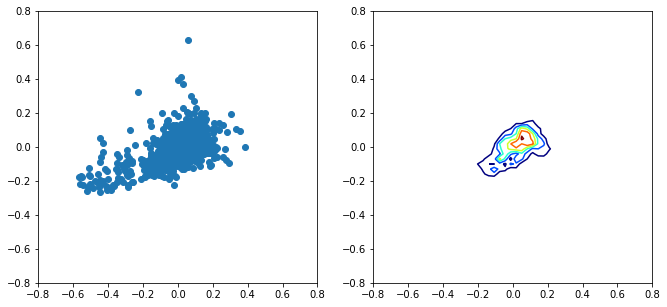

In [20]:
def show_heatmap_density_contour(X,Y,bins=20,linestyles='solid'):
    
    if np.size(bins)==1:
        bins = [bins,bins]
    
    Z,xedges,yedges = np.histogram2d(X,Y,bins=bins)

    xx = .5*(xedges[:-1]+xedges[1:])
    yy = .5*(yedges[:-1]+yedges[1:])

    xv,yv = np.meshgrid(xx,yy)
    
    plt.contour(xv.T,yv.T,Z,cmap='jet',linestyles=linestyles)

    
    # Sample from learned GMM

prop_q = gmm_model.sample(sample_shape=FLAGS.batch_size)


a = 0.8
q_samples = tf_eval(prop_q,1000)

_ = plt.figure(figsize=(11,5))
_ = plt.subplot(1,2,1)
_ = plt.scatter(q_samples[:,0],q_samples[:,1])
_ = plt.xlim([-a,a])
_ = plt.ylim([-a,a])
_ = plt.subplot(1,2,2)
show_heatmap_density_contour(q_samples[:,0],q_samples[:,1],bins=30)
_ = plt.xlim([-a,a])
_ = plt.ylim([-a,a])

In [21]:
def check_dist(a_0=-1, b_0=1):
    nbin = 50

    x_grid = np.linspace(a_0,b_0,nbin)
    y_grid = np.linspace(a_0,b_0,nbin)

    xv, yv = np.meshgrid(x_grid, y_grid, sparse=False, indexing='ij')

    txy = np.concatenate([xv.reshape([-1,1]),yv.reshape([-1,1])],axis=1)

    dx = x_grid[1] - x_grid[0]
    dy = y_grid[1] - y_grid[0]
    dxy = dx*dy


    psi_xy = tf_eval(u_x,nbin**2,feed_dict={input_x: txy})
    psi_xy = psi_xy.reshape([nbin,nbin])
    
    gmm_psi_xy = -sess.run(gmm_model.log_prob(txy))
    gmm_psi_xy = gmm_psi_xy.reshape([nbin,nbin])

    uxy_mdl = np.exp(-psi_xy)
    mdl_partition = np.sum(dxy*uxy_mdl)

    _ = plt.figure(figsize=(11,5))
    _ = plt.subplot(1,2,1)
    plt.scatter(q_samples[:,0],q_samples[:,1])
    _ = plt.contour(xv,yv,np.exp(-gmm_psi_xy))
    
    _ = plt.xlim([a_0,b_0])
    _ = plt.ylim([a_0,b_0])
    _ = plt.title('GMM')
    _ = plt.subplot(1,2,2)
    plt.scatter(q_samples[:,0],q_samples[:,1])
    _ = plt.contour(xv,yv,np.exp(-psi_xy))
    _ = plt.title('FML')


    
    _ = plt.show()

In [22]:
initializer = tf.global_variables_initializer()
sess.run(initializer)

In [23]:
# Initialize normalizing constant estimate b to zero when using 
# GMM as baseline

sess.run(tf.assign(b,np.reshape(np.array([0]),[1,])))
sess.run(b)

array([0.], dtype=float32)

[-0.1205396]
Initialization


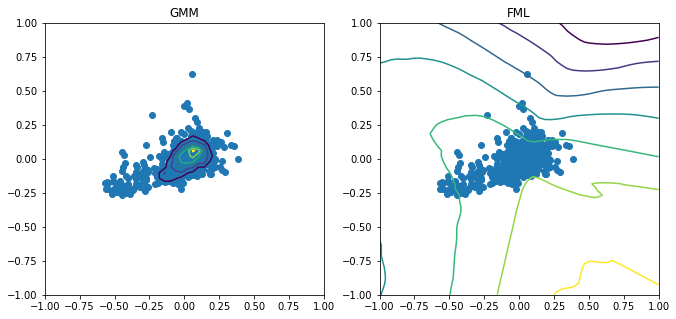

0 0.18014607
1 -0.36265728
2 -0.5776646
3 -0.84387046


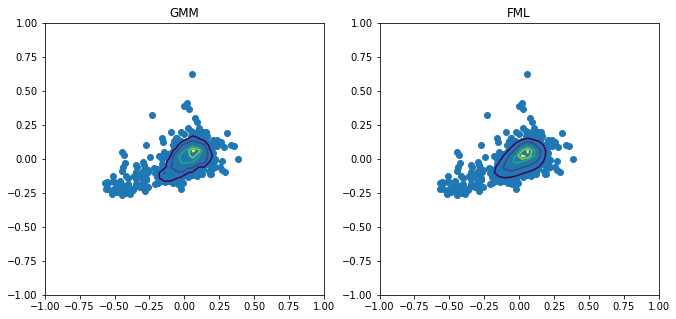

4 -1.0486636
5 -0.88867533
6 -0.7118293
7 -0.7715133
8 -1.0035458


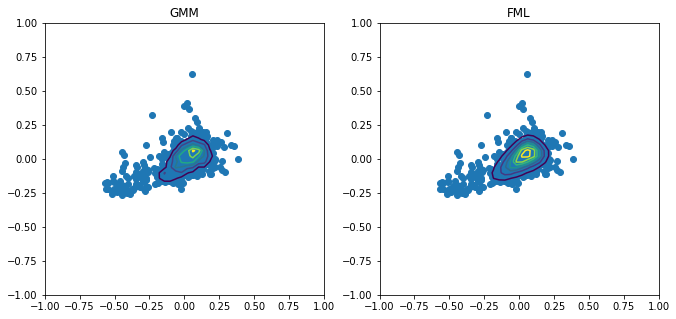

9 -0.8464495
10 -0.7511413
11 -0.74133754
12 -1.0944066
13 -0.8291303


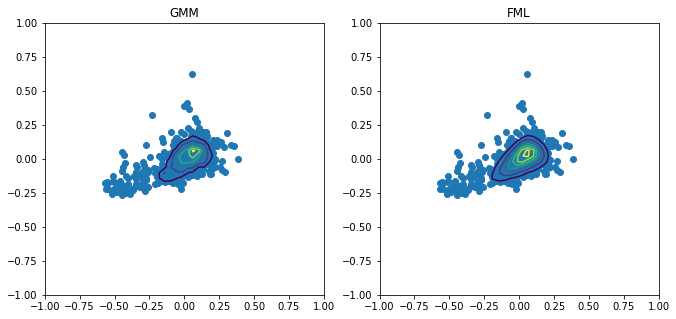

14 -0.9667889
15 -0.8892432
16 -0.8016124
17 -1.0029407
18 -1.0925857


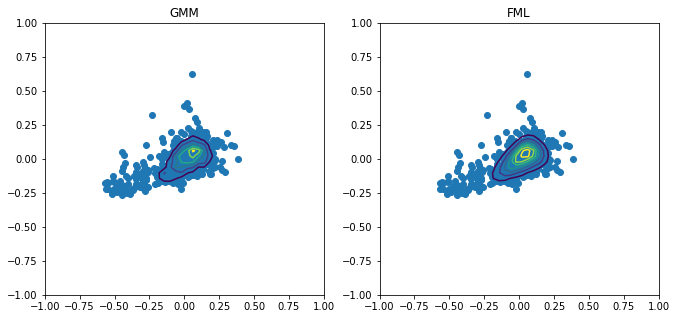

19 -0.8182699
40.55925893783569


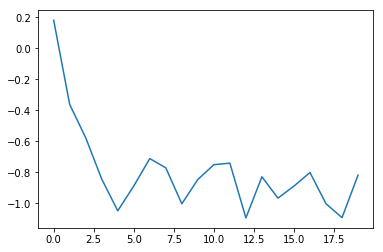

In [24]:
lr = 3e-3
max_updates = 500
num_iter = 20

t0 = time();

loss_record = []

n_samples = np.shape(x_train)[0]

# Pre-train normalizing constant b

for step in range(max_updates):
    
    inds = np.random.choice(n_samples,FLAGS.batch_size)
    xx = x_train[inds]
    
    _ = sess.run([train_u],{input_x: xx, learning_rate: lr})
    
print(sess.run(b))

print('Initialization')
check_dist()


for iterId in range(num_iter):
    
    for step in range(max_updates):
        
        inds = np.random.choice(n_samples,FLAGS.batch_size)
        xx = x_train[inds]
        
        # FML training
        _,_ = sess.run([train_u, train_psi],{input_x: xx, learning_rate: lr})
        
    if np.mod(iterId+1,5)==0:
        check_dist()
        
    loss_val = sess.run(loss,{input_x: xx})
    print(iterId, loss_val)
    loss_record.append(loss_val)
        
_ = plt.plot(loss_record)


t1 = time()
print(t1-t0)

In [25]:
import tensorflow_probability as tfp
tfd = tfp.distributions
from sklearn import mixture

def normalizer(target_log_prob, num_steps = 1000, num_chains = 3000, dims = 2, dtype = tf.float32):
    proposal = tfd.MultivariateNormalDiag(
        loc=tf.zeros(dims, dtype=dtype))

    chains_state, ais_weights, kernels_results = (
        tfp.mcmc.sample_annealed_importance_chain(
            num_steps=num_steps,
            proposal_log_prob_fn = proposal.log_prob,
            target_log_prob_fn = target_log_prob,

            current_state = proposal.sample(num_chains),
            make_kernel_fn = lambda tlp_fn: tfp.mcmc.HamiltonianMonteCarlo(
              target_log_prob_fn = tlp_fn,
              step_size = 0.2,
              num_leapfrog_steps = 2)))

    log_estimated_normalizer = (tf.reduce_logsumexp(ais_weights)
                                - np.log(num_chains))
    normalizer = tf.exp(log_estimated_normalizer)
    return normalizer

In [26]:
# Verifying the model is properly self-normalized 
# If estimated accurately, estimated_norm will be close to 1

psi_vec = lambda x: tf.reshape(-psi(x)-b,[-1,])

estimated_normalizer = normalizer(psi_vec,num_steps = 5000, num_chains = 3000)

estimated_norm = sess.run(estimated_normalizer)
print('Normalizaing constant = %.2f'%estimated_norm)

Normalizaing constant = 1.03
